## Environment preparation

### Imports

In [1]:
import os
import csv
import torch
import pandas as pd
import matplotlib.pyplot as plt

from gpolnel.utils.datasets import load_boston
from torch.utils.data import TensorDataset, DataLoader

from gpolnel.problems.inductive_programming import SML
from gpolnel.problems.neuroevolution import SMLNN
from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.inductive_programming import function_map
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm
from gpolnel.operators.initializers import grow, full, rhh, prm_grow, ERC, prm_full, nn_init
from gpolnel.operators.variators import swap_xo, prm_subtree_mtn, prm_point_mtn, prm_hoist_mtn, nn_xo, prm_nn_mtn
from gpolnel.operators.selectors import prm_tournament, prm_roulette_wheel, prm_rank_selection, prm_rnd_selection, prm_double_tournament


### Global settings

In [2]:
seed = 19
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'mps' if torch.backends.mps.is_available() else 'cpu'
    

### Data load

In [3]:
# Defines parameters for the data usage
shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1


In [4]:
csv_file_path = '../datamart/data_project_nel_final.csv'

# Read the CSV file into a DataFrame
dt = pd.read_csv(csv_file_path)
X = torch.from_numpy(dt.values[:, :-1]).float().to(device)

In [5]:
csv_file_path = '../datamart/y_lactose.csv'

y_lactose = pd.read_csv(csv_file_path)
y = torch.from_numpy(y_lactose.values[:, -1]).float().to(device)

In [6]:
print(X.shape, y.shape)
print(X[:3])
print(y[:3])

torch.Size([324, 11]) torch.Size([324])
tensor([[ 2.5000,  2.0000, -0.5206, -1.3631, -0.5860,  0.7581, -0.5366,  0.8808,
          0.0000,  0.0000, -0.4190],
        [ 3.0000,  0.8657, -0.7277,  0.6837, -0.3605,  1.0324, -0.8866,  0.0796,
          0.0000,  0.0000, -0.6626],
        [ 2.0000,  0.0299,  0.3326,  0.0628,  0.4168, -0.0605, -0.6421,  0.1936,
          0.0000,  0.1330, -0.5441]], device='cuda:0')
tensor([4.9535, 4.9831, 4.8891], device='cuda:0')


In [7]:
# Data split

# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, p_test=p_test, seed=seed)

# Train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, p_test=p_val, seed=seed)
total_batches = 1
batch_size = X_train.shape[0]
print('Batch size: {}\nTotal batches: {}\n'.format(batch_size, total_batches))

print('Train:\t{}\nVal:\t{}\nTest:\t{}'.format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))
print('Total:\t{}'.format(X_train.shape[0] + X_val.shape[0] + X_test.shape[0]))

# Creates training and validatation data sets
ds_train = TensorDataset(X_train, y_train)
ds_val = TensorDataset(X_val, y_val)
ds_test = TensorDataset(X_test, y_test)

# Creates training and test data loaders
dl_train = DataLoader(ds_train, batch_size, shuffle)
dl_val = DataLoader(ds_val, batch_size, shuffle)
dl_test = DataLoader(ds_test, batch_size, shuffle)

Batch size: 159
Total batches: 1

Train:	159
Val:	68
Test:	97
Total:	324


## Grid search

Create combinations for grid search

In [8]:
import itertools
import torch

# Define ranges for grid search for neural network parameters
init_factor_list = [0.01, 0.1]
n_hidden_neurons_list = [[4, 5], [8, 8], [16, 16], [32, 32]]
activation_list = [
    [torch.relu, torch.relu, None], 
    [torch.sigmoid, torch.sigmoid, None],
    [torch.tanh, torch.tanh, None]
]

selectors = [prm_tournament, prm_roulette_wheel, prm_rank_selection, prm_rnd_selection] 

# Define ranges for grid search for genetic algorithm parameters
ps_list = [100, 250, 500]
mutation_step_list = [0.1, 0.25, 0.5]
mutation_prob_list = [0.1, 0.5, 0.9]
xo_prob_list = [0.05, 0.1, 0.2]
selection_pressure_list = [0.05, 0.07, 0.1]
has_elitism_list = [True, False]
allow_reproduction_list = [True, False]



# Create combinations
combinations = list(itertools.product(
    init_factor_list,
    n_hidden_neurons_list,
    activation_list,
    selectors,
    ps_list,
    mutation_step_list,
    mutation_prob_list,
    xo_prob_list,
    selection_pressure_list,
    has_elitism_list,
    allow_reproduction_list
))


Choose 10 randomly as it would not be feasible to use all the combinations

In [9]:
import random
random.seed(11)

selected_combinations = random.sample(combinations, 10)

Perform grid search

In [10]:
best_sol = float('inf')
best_params = {}


def test_genetic_algorithm(init_factor, n_hidden_neurons, activation, selector, ps, mutation_step, mutation_prob, xo_prob, selection_pressure, has_elitism, allow_reproduction):
    global best_sol, best_params
    
    sspace_nn = {
    'input_shape': X.shape[1],
    #
    # NN specifications
    #
    'init_factor': init_factor,
    'n_hidden_neurons': n_hidden_neurons,
    'activation': activation,
    'n_output': 1,
    #
    #
    #
    'n_batches': total_batches,
    'device': device
}

    pi_sml = SMLNN(
    sspace=sspace_nn,
    ffunction=Ffunctions('rmse'),
    dl_train=dl_train, dl_test=dl_val,  # For the algorithm, the unseen is our validation!
    n_jobs=8
)
    if selector==prm_tournament:
        selector = prm_tournament(pressure=selection_pressure)
    elif selector==prm_double_tournament:
        selector = prm_double_tournament(pressure1=selection_pressure, pressure2=selection_pressure)
    else:
        selector = selector()
        
    mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=nn_init,
    selector=selector,
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed,
    #
    # As in the example of using the traditional GSGP with GPOL, for Neuroevolution of the NN hyperparameters,
    # the algorithm is a GA object, and we specify the specific XO and Mutation operators.
    # In this case, however, to handle with NNs.
    #
    crossover=nn_xo,
    mutator=prm_nn_mtn(ms=mutation_step, sspace=sspace_nn)
)

    mheuristic._initialize()  # GP initialization


    # Learning
    n_iter = 50
    mheuristic.solve(
        n_iter,
        test_elite=True
    )
    
    current_sol = float(mheuristic.best_sol.test_fit.item())
    
    if current_sol < best_sol:
        best_sol = current_sol
        best_params = (
            init_factor, n_hidden_neurons, activation, selector, ps, mutation_step, mutation_prob, xo_prob, selection_pressure, has_elitism, allow_reproduction
        )

    return best_params, best_sol

In [11]:
from tqdm import tqdm

for combo in tqdm(selected_combinations, desc="Testing Combinations"):
    init_factor, n_hidden_neurons, activation, selector, ps, mutation_step, mutation_prob, xo_prob, selection_pressure, has_elitism, allow_reproduction = combo
    test_genetic_algorithm(init_factor, n_hidden_neurons, activation, selector, ps, mutation_step, mutation_prob, xo_prob, selection_pressure, has_elitism, allow_reproduction)
    
print(f"Best Parameters: {best_params}")
print(f"Best Solution: {best_sol}")

Testing Combinations: 100%|██████████| 10/10 [02:17<00:00, 13.70s/it]

Best Parameters: (0.1, [8, 8], [<built-in method tanh of type object at 0x00007FFC741B49E0>, <built-in method tanh of type object at 0x00007FFC741B49E0>, None], <function prm_tournament.<locals>.tournament at 0x0000024D55571300>, 250, 0.25, 0.1, 0.2, 0.1, False, False)
Best Solution: 0.06721422076225281


Now that we have the best parameters, we use them to train the model and then evaluate the results on the test set

In [12]:
init_factor, n_hidden_neurons, activation, selector, ps, mutation_step, mutation_prob, xo_prob, selection_pressure, has_elitism, allow_reproduction = best_params

In [13]:
best_params

(0.1,
 [8, 8],
 [<function torch._VariableFunctionsClass.tanh>,
  <function torch._VariableFunctionsClass.tanh>,
  None],
 <function gpolnel.operators.selectors.prm_tournament.<locals>.tournament(pop, min_)>,
 250,
 0.25,
 0.1,
 0.2,
 0.1,
 False,
 False)

In [14]:
sspace_nn = {
'input_shape': X.shape[1],
#
# NN specifications
#
'init_factor': init_factor,
'n_hidden_neurons': n_hidden_neurons,
'activation': activation,
'n_output': 1,
#
#
#
'n_batches': total_batches,
'device': device
}

pi_sml = SMLNN(
sspace=sspace_nn,
ffunction=Ffunctions('rmse'),
dl_train=dl_train, dl_test=dl_test,  # For the algorithm, the unseen is our validation!
n_jobs=8
)


mheuristic = GeneticAlgorithm(
pi=pi_sml,
initializer=nn_init,
selector=selector,
pop_size=ps,
p_m=mutation_prob,
p_c=xo_prob,
elitism=has_elitism,
reproduction=allow_reproduction,  # False = or xo or mutation
device=device,
seed=seed,
#
# As in the example of using the traditional GSGP with GPOL, for Neuroevolution of the NN hyperparameters,
# the algorithm is a GA object, and we specify the specific XO and Mutation operators.
# In this case, however, to handle with NNs.
#
crossover=nn_xo,
mutator=prm_nn_mtn(ms=mutation_step, sspace=sspace_nn)
)

mheuristic._initialize()  # GP initialization


# Log settings
file_dir = './log_ne_gpol/'
file_name = 'intro_nn.log'
log_path = file_dir + file_name
if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)


# Learning
n_iter = 50
mheuristic.solve(
    n_iter, verbose=3, log=2, log_path=log_path,
    test_elite=True
)


-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Length   Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 2        2.45053          2.4616                0.099 | 4.92557                   1.02276
1          | 2        1.91713          1.92631               0.245 | 3.10021                  0.513663
2          | 2        1.41033          1.3969                0.238 | 2.19834                  0.340088
3          | 2        0.428597         0.434496              0.233 | 1.6296                   0.364844
4          | 2        0.142311         0.126922              0.235 | 

GP Evolution

In [16]:
# Open log file
rows = []
with open(log_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Process each row (each row is a list of values)
        rows.append(row)

# Fitness history
history_fits = [float(row[7].split('(')[1].split(')')[0]) for row in rows]

# Val fitness history
history_val_fits = [float(row[9].split('(')[1].split(')')[0]) for row in rows]

# Solution size history
history_sizes = [int(row[6]) for row in rows]

# Runtime
history_timing = [float(row[5]) for row in rows]

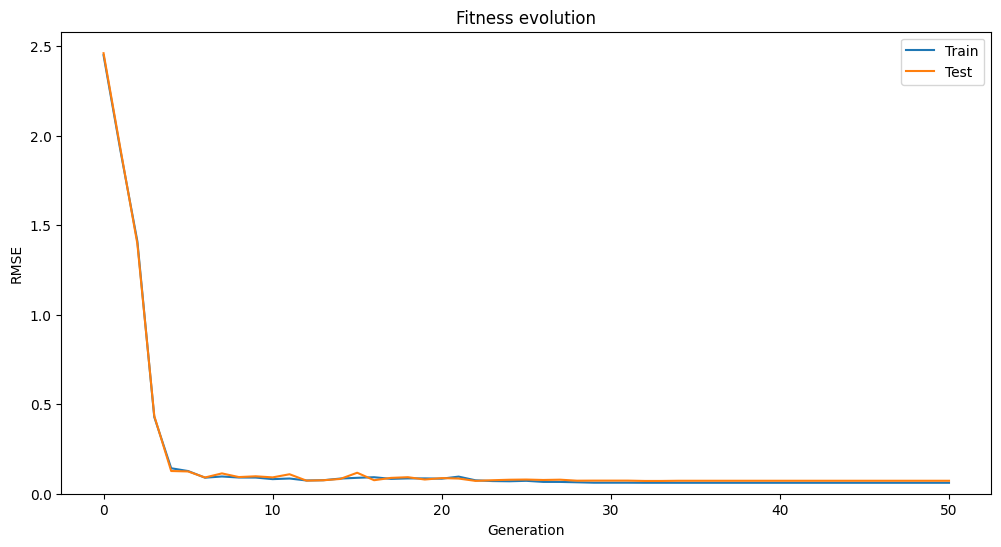

Best solution RMSE fitness: 0.0611 train, 0.0724 test.



In [17]:
plt.figure(figsize=(12, 6))

plt.plot(history_fits, label='Train')
plt.plot(history_val_fits, label='Test')
plt.title('Fitness evolution')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.ylim(bottom=0)
plt.legend()
plt.show()

print('Best solution RMSE fitness: {:.4f} train, {:.4f} test.\n'.format(mheuristic.best_sol.fit.item(), mheuristic.best_sol.test_fit.item()))


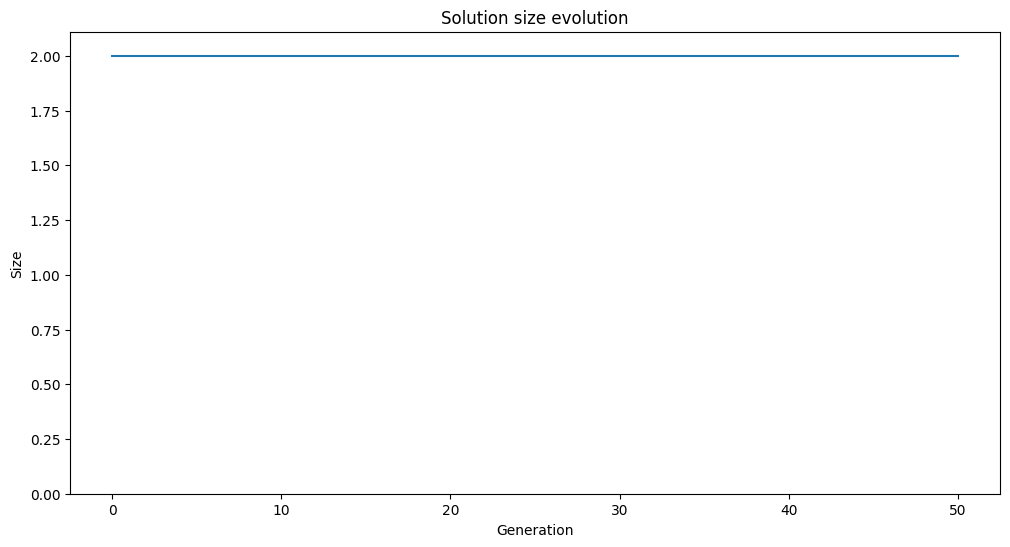

In [18]:
plt.figure(figsize=(12, 6))

plt.plot(history_sizes)
plt.title('Solution size evolution')
plt.xlabel('Generation')
plt.ylabel('Size')
plt.ylim(bottom=0)
plt.show()


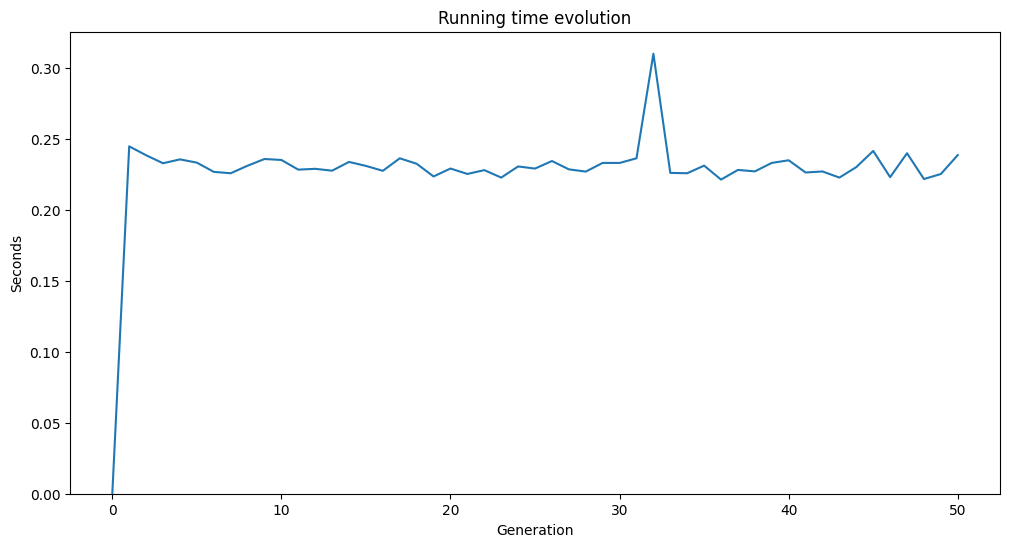

Total time: 0.19 minutes.



In [19]:
plt.figure(figsize=(12, 6))

plt.plot(history_timing)
plt.title('Running time evolution')
plt.xlabel('Generation')
plt.ylabel('Seconds')
plt.ylim(bottom=0)
plt.show()

print('Total time: {:.2f} minutes.\n'.format(sum(history_timing)/60.))
